In [29]:
%config IPCompleter.greedy=True
%matplotlib inline
import pandas as pd

feature_pos = [[0,8],[8,12],[12,28],[28,44],[44,52],[52,64],[64,80],[80,92],[92,102]] 
df_train = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('sample_solution.csv')
Y = df_train['Label'].values

In [2]:
import numpy as np

dataframes = np.load('allData.npy', allow_pickle = True)
dataframes.shape

def load_test_dataframe(id):
    test_data = np.load("test/test/{}.npy".format(id))
    return pd.DataFrame(data=test_data)

testdatas = []
for id in df_test['Id']:
    dfi = load_test_dataframe(id)
    testdatas.append(dfi.values)

In [88]:
from tqdm import tqdm

def handle_integers(dfs, col):
    data = []
    for df in dfs:
        sumCol = np.sum(df[:,col], axis=0).reshape(1, -1)
        meanCol = np.mean(df[:, col], axis=0).reshape(1, -1)
        dataCol = np.concatenate((sumCol, meanCol), axis=1)
        # dataCol = sumCol
        # print(dataCol.shape)
        data.append(dataCol)
    data = np.concatenate(data, axis=0)    
    # print(data.shape)
    return data

def handle_integers_feature(dfs, feature):
    if feature != 8:
        return None
    data = handle_integers(dfs, feature_pos[feature][0])
    for col in tqdm(range(feature_pos[feature][0] + 1,feature_pos[feature][1])):
        dataCol = handle_integers(dfs, col)
        data = np.concatenate((data, dataCol), axis=1)
    return data

def one_hot_encoding(encoder, dfs, col):
    if encoder == None:
        data = set(dfs[0][:,col])
        for i in range(1,len(dfs)):
            df = dfs[i]
            data |= set(df[:,col])
        encoder = OneHotEncoder(handle_unknown='ignore')
        encoder = encoder.fit([[str(e)] for e in data])
    encodedData = []
    for df in dfs:
        mat = np.sum(encoder.transform([[str(e)] for e in df[:,col]]), axis=0)
        mat = np.squeeze(np.asarray(mat))
        encodedData.append(mat)
    encodedData = np.stack(encodedData)    
    return encoder, encodedData

def one_hot_encoding_feature(encoders, dfs, feature):
    if feature == 8:
        return None, None
    
    if len(encoders) == 0:
        encoder, data = one_hot_encoding(None, dfs, feature_pos[feature][0])
        encoders.append(encoder)    
        for col in tqdm(range(feature_pos[feature][0] + 1,feature_pos[feature][1])):
            encoder, dataCol = one_hot_encoding(None, dfs, col)
            encoders.append(encoder)
            data = np.concatenate((data, dataCol), axis=1)
    else:        
        encoder, data = one_hot_encoding(encoders[0], dfs, feature_pos[feature][0])
        for col in tqdm(range(feature_pos[feature][0] + 1,feature_pos[feature][1])):
            i = col - feature_pos[feature][0]
            encoder, dataCol = one_hot_encoding(encoders[i], dfs, col)
            data = np.concatenate((data, dataCol), axis=1)
    return encoders, data

In [89]:
train = handle_integers_feature(dataframes, 8)
test = handle_integers_feature(testdatas, 8)
print(train.shape)
print(test.shape)

100%|█████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.92it/s]


(18662, 20)
(6051, 20)


In [92]:
columnNames = []
for i in range(feature_pos[-1][0], feature_pos[-1][1]):
    iF = i - feature_pos[-1][0]
    columnNames.append(str(i) + '_' + str(iF) + '_sum')
    columnNames.append(str(i) + '_' + str(iF) +  '_mean')

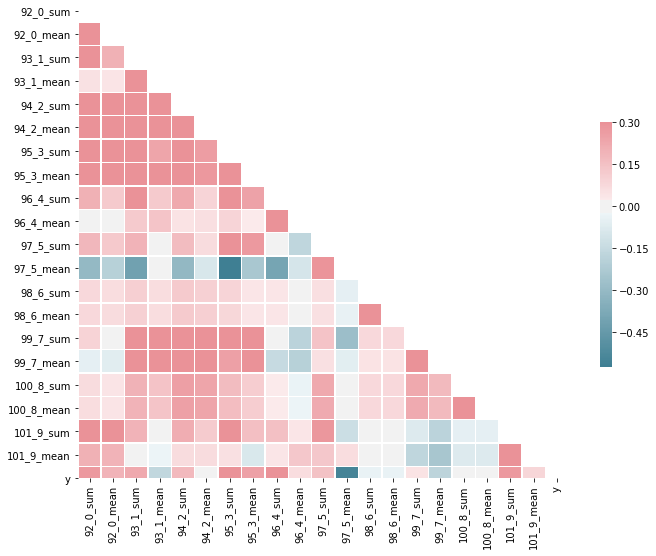

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

df_train = pd.DataFrame(data=train,
                 columns=columnNames)
df_train['y'] = Y
plot_corr(df_train)

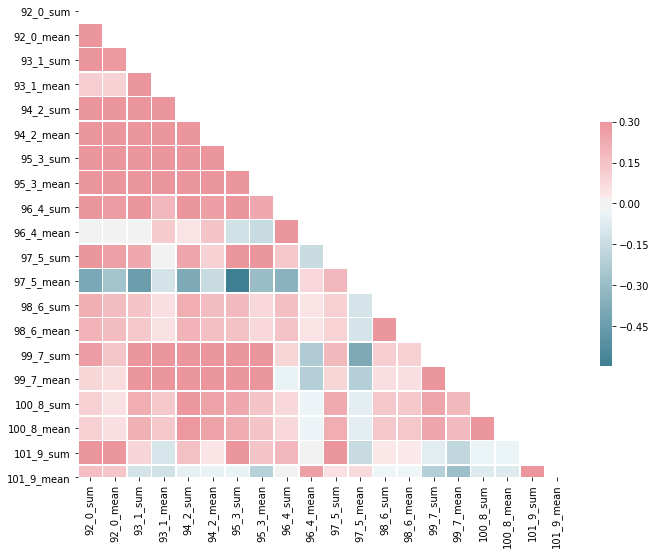

In [94]:
df_test = pd.DataFrame(data=test,
                 columns=columnNames)
plot_corr(df_test)

In [103]:
df_train.corr()['y'].sort_values(ascending=False)

y             1.000000
95_3_sum      0.504307
96_4_sum      0.324232
92_0_sum      0.275943
101_9_sum     0.273843
95_3_mean     0.249349
93_1_sum      0.222272
92_0_mean     0.195105
94_2_sum      0.175531
97_5_sum      0.149416
101_9_mean    0.084959
96_4_mean     0.061119
99_7_sum      0.045422
100_8_sum     0.005243
100_8_mean    0.000841
94_2_mean    -0.024203
98_6_sum     -0.037313
98_6_mean    -0.037605
93_1_mean    -0.164197
99_7_mean    -0.175488
97_5_mean    -0.549821
Name: y, dtype: float64

In [102]:
df_train.corr()['y']

92_0_sum      0.275943
92_0_mean     0.195105
93_1_sum      0.222272
93_1_mean    -0.164197
94_2_sum      0.175531
94_2_mean    -0.024203
95_3_sum      0.504307
95_3_mean     0.249349
96_4_sum      0.324232
96_4_mean     0.061119
97_5_sum      0.149416
97_5_mean    -0.549821
98_6_sum     -0.037313
98_6_mean    -0.037605
99_7_sum      0.045422
99_7_mean    -0.175488
100_8_sum     0.005243
100_8_mean    0.000841
101_9_sum     0.273843
101_9_mean    0.084959
y             1.000000
Name: y, dtype: float64

In [96]:
np.max(df_train['95_3_sum'])

5760.2188

In [97]:
np.min(df_train['95_3_sum'])

0.0

In [98]:
np.max(df_train['96_4_sum'])

2058.0

In [99]:
# df_train.to_csv('explore_f9.csv')

In [100]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics

XTrain, X_valid, y_train, y_valid = train_test_split(train, Y, test_size=0.2, random_state=42)
model = LGBMClassifier()
model.fit(XTrain, y_train)
pred = model.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_valid, pred)
auc_score = metrics.auc(fpr, tpr)
auc_score

0.981394104768485